In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf

### Check Version

In [2]:
tf.__version__

'2.9.1'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

2022-11-01 03:53:21.744637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 03:53:21.751655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 03:53:21.752110: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps

In [15]:
def trainPreprocessA(img, lab):
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        return img, lab

In [16]:
def preprocessB(img, lab, rotL, rotH, shXL, shXH, shYL, shYH, zoomL, zoomH, hTransL, hTransH, vTransL, vTransH):
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    rRot = tf.random.uniform([shape[0]], minval=rotL, maxval=rotH, dtype=tf.float32)
    rShearX = tf.random.uniform([shape[0]], minval=shXL, maxval=shXH, dtype=tf.float32)
    rShearY = tf.random.uniform([shape[0]], minval=shYL, maxval=shYH, dtype=tf.float32)
    rZoom = tf.random.uniform([shape[0]], minval=zoomL, maxval=zoomH, dtype=tf.float32) #% Zoom
    rTx = tf.random.uniform([shape[0]], minval=hTransL, maxval=hTransH, dtype=tf.float32) #% Horiz Translation
    rTy = tf.random.uniform([shape[0]], minval=vTransL, maxval=vTransH, dtype=tf.float32) #% Vert Translation

    cT = tf.math.cos(rRot)
    sT = tf.math.sin(rRot)

    one = tf.ones([shape[0]], dtype=tf.float32)
    zero = tf.zeros([shape[0]], dtype=tf.float32)

    transC = tf.stack([[1, 0, -shapeF[2]/2], [0, 1, -shapeF[1]/2], [0, 0, 1]])
    transCI = tf.stack([[1, 0, shapeF[2]/2], [0, 1, shapeF[1]/2], [0, 0, 1]])

    trans = tf.transpose(tf.stack([[one, zero, rTx*shapeF[2]], [zero, one, rTy*shapeF[1]], [zero, zero, one]]), [2,0,1])
    rot = tf.transpose(tf.stack([[cT, -sT, zero], [sT, cT, zero], [zero, zero, one]]), [2,0,1])
    scale = tf.transpose(tf.stack([[rZoom, rShearX, zero], [rShearY, rZoom, zero], [zero, zero, one]]), [2,0,1])

    rotScale = rot@scale

    afTMat = transCI @ trans @ rotScale @ transC
    afT = tf.reshape(afTMat, [shape[0], -1])[:,:-1]

    img = tf.raw_ops.ImageProjectiveTransformV3(interpolation='NEAREST', images=img, transforms=afT, output_shape=shape[1:3], fill_value=0)

    return img, lab

In [17]:
def preprocessNoise(img, lab, gMean, gStd, spAmountP, spRatio, speckleVar):
        
    shape = tf.shape(img)
    shapeF = tf.cast(shape, tf.float32)

    # Gaussian Noise
    gNoise = tf.random.normal(shape, gMean, gStd)

    img += gNoise

    # Salt and pepper noise
    spMask = tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spAmountP), tf.float32)
    spNoise = 255*tf.cast(tf.math.less(tf.random.uniform(shape, dtype=tf.float32), spRatio), tf.float32)

    img = tf.math.add(tf.math.multiply(img, 1.0 - spMask), tf.math.multiply(spNoise, spMask))

    # Speckles
    sNoise = speckleVar * tf.random.normal(shape)
    img = img + tf.math.multiply(img, sNoise)

    img = tf.clip_by_value(img, 0, 255)

    return img, lab

In [18]:
def clipValue(img, lab):
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img, lab

In [19]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [20]:
def prepareLabel(img, lab):
    
    lab = lab['gender']
    
    return img, {"recon" : img, "gender" : lab }

### Generate Folds for K-Folds validation

In [21]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [22]:
genParams = {
            "rotation": [-math.pi, math.pi],
            "shearX": [-0.2, 0.2],
            "shearY": [-0.2, 0.2],
            
            "zoom": [0.8, 1.2], # +- 20%
            "hTranslation": [-0.2, 0.2], # +- 20%
            "vTranslation": [-0.2, 0.2], # +- 20%
            
            "gaussianMean": 0.0,
            "gaussianStd": 2.0,
            
            "spAmount": 0.0001,
            "spRatio": 0.5,
            
            "speckleVar": 0.01
        }

In [23]:
trainPreprocessB = partial(preprocessB,
                           rotL = genParams['rotation'][0],
                           rotH = genParams['rotation'][1],
                           shXL = genParams['shearX'][0],
                           shXH = genParams['shearX'][1], 
                           shYL = genParams['shearY'][0],
                           shYH = genParams['shearY'][1],
                           zoomL = genParams['zoom'][0],
                           zoomH = genParams['zoom'][1],
                           hTransL = genParams['hTranslation'][0],
                           hTransH = genParams['hTranslation'][1],
                           vTransL = genParams['vTranslation'][0],
                           vTransH = genParams['vTranslation'][1])

In [24]:
trainPreprocessC = partial(preprocessNoise,
                           gMean = genParams['gaussianMean'],
                           gStd = genParams['gaussianStd'],
                           spAmountP = genParams['spAmount'],
                           spRatio = genParams['spRatio'],
                           speckleVar = genParams['speckleVar'])

In [25]:
trainPreBatch = [("train_process_a", trainPreprocessA)]
trainPostBatch = [("train_process_b", trainPreprocessB),
                  ("train_process_c", trainPreprocessC),
                  ("train_clip", clipValue),
                  ("train_prepare_label", prepareLabel)]

valPreBatch = [("val_prepare_label", prepareLabel)]

In [26]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       trainPostBatch=trainPostBatch,
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-01 03:53:22.023603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 03:53:22.024332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 03:53:22.024664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-01 03:53:22.024949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [27]:
len(folds)

5

### Check data

In [28]:
for x,y in folds[0][0].take(1):
    pass

In [29]:
x

<tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [2.3655400e+00, 0.0000000e+00, 0.0000000e+00],
         [1.5267088e+00, 2.0888946e+00, 0.0000000e+00],
         ...,
         [5.9030060e+01, 4.1294956e+01, 3.1735863e+01],
         [5.8430119e+01, 3.7679359e+01, 3.3113323e+01],
         [7.0120605e+01, 4.7874397e+01, 4.2625481e+01]],

        [[0.0000000e+00, 1.3474641e+00, 2.0787053e-01],
         [8.0581617e-01, 5.7664331e-02, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [7.5792465e+01, 5.5602314e+01, 4.6211018e+01],
         [7.7786324e+01, 5.5127838e+01, 4.7111874e+01],
         [8.2398163e+01, 5.8483990e+01, 4.4980461e+01]],

        [[5.9281719e-01, 1.3315732e+00, 0.0000000e+00],
         [1.8286966e+00, 9.3663728e-01, 1.5494574e+00],
         [4.5377898e+00, 0.0000000e+00, 2.1395895e-01],
         ...,
         [8.4244171e+01, 5.5378014e+01, 4.8734116e+01],


In [30]:
y

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          [2.3655400e+00, 0.0000000e+00, 0.0000000e+00],
          [1.5267088e+00, 2.0888946e+00, 0.0000000e+00],
          ...,
          [5.9030060e+01, 4.1294956e+01, 3.1735863e+01],
          [5.8430119e+01, 3.7679359e+01, 3.3113323e+01],
          [7.0120605e+01, 4.7874397e+01, 4.2625481e+01]],
 
         [[0.0000000e+00, 1.3474641e+00, 2.0787053e-01],
          [8.0581617e-01, 5.7664331e-02, 0.0000000e+00],
          [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
          ...,
          [7.5792465e+01, 5.5602314e+01, 4.6211018e+01],
          [7.7786324e+01, 5.5127838e+01, 4.7111874e+01],
          [8.2398163e+01, 5.8483990e+01, 4.4980461e+01]],
 
         [[5.9281719e-01, 1.3315732e+00, 0.0000000e+00],
          [1.8286966e+00, 9.3663728e-01, 1.5494574e+00],
          [4.5377898e+00, 0.0000000e+00, 2.1395895e-01],
          ...,
          [8.4244171e+01, 

<IPython.core.display.Javascript object>


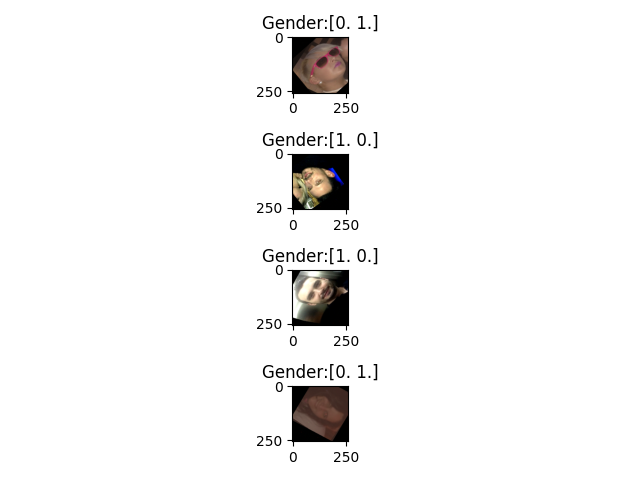

In [31]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y['gender'][i]}")
        
plt.tight_layout()

### Model

In [32]:
def createModel():
    inp = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    encoder = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 2, strides=(2,2), activation='relu', name='enc_conv1'),
        tf.keras.layers.Conv2D(64, 2, strides=(2,2), activation='relu', name='enc_conv2'),
        tf.keras.layers.Conv2D(64, 2, strides=(2,2), activation='relu', name='enc_conv3'),
        tf.keras.layers.Conv2D(64, 2, strides=(2,2), activation='relu', name='enc_conv4'),
        tf.keras.layers.Conv2D(8, 2, strides=(2,2), activation='relu', name='enc_conv5')
    ], name='enc')
    
    decoder = tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2), activation='relu', name='dec_deconv1'),
        tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2), activation='relu', name='dec_deconv2'),
        tf.keras.layers.Conv2DTranspose(64, 2, strides=(2,2), activation='relu', name='dec_deconv3'),
        tf.keras.layers.Conv2DTranspose(32, 2, strides=(2,2), activation='relu', name='dec_deconv4'),
        tf.keras.layers.Conv2DTranspose(3, 2, strides=(2,2), activation='tanh', name='dec_deconv5')
    ], name='dec')

    flat1 = tf.keras.layers.Flatten(name='flat1')
    fc1 = tf.keras.layers.Dense(128, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='gender_out')
    
    # Preprocess Input
    preInp = inp / 127.5 - 1.0
    
    latent = encoder(preInp)
    recon = decoder(latent)
    recon = tf.math.multiply((recon + 1.0), 127.5, name='recon')
    
    latentFlat = flat1(latent)
    o = fc1(latentFlat)
    o = do1(o)
    
    outLab = fc2(o)
    

    model = tf.keras.models.Model(inputs=inp, outputs={"recon": recon, "gender": outLab}, name='AE_1')
    
    return model

In [33]:
model = createModel()

In [34]:
model.summary()

Model: "AE_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 256, 256, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 enc (Sequential)               (None, 8, 8, 8)      43624       ['tf.math.subtract[0][0]']    

### Compile Model

In [35]:
STEPS_PER_EPOCH = 1000
EPOCH = 300

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [36]:
def schedule(epoch, lr):
    return lr

In [37]:
logBasePath = "log/AE_1"
logPrefix = "log"

In [38]:
for i, (train, val) in enumerate([folds[0]]):
    
    model = createModel()
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    loss = {"gender": tf.keras.losses.CategoricalCrossentropy(), "recon": tf.keras.losses.MeanSquaredError()}
    metrics = {"gender": 'accuracy'}
    
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
    lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
    cbs = [tboardCb]
    
    model.evaluate(val)
    model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)

2022-11-01 03:53:37.342396: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 03:53:37.342416: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-01 03:53:37.342435: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-01 03:53:37.450630: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 03:53:37.451953: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-01 03:53:38.073715: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  17/3528 [..............................] - ETA: 11s - loss: 5613.4214 - gender_out_loss: 0.6812 - tf.math.multiply_1_loss: 5612.7397 - gender_out_accuracy: 0.5882    

2022-11-01 03:53:38.825335: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3528/3528 [==============================] - 12s 3ms/step - loss: 5991.5737 - gender_out_loss: 0.6944 - tf.math.multiply_1_loss: 5990.8599 - gender_out_accuracy: 0.4770
Epoch 1/300
   1/1000 [..............................] - ETA: 12:45 - loss: 6646.3408 - gender_out_loss: 0.6798 - tf.math.multiply_1_loss: 6645.6611 - gender_out_accuracy: 0.7500

2022-11-01 03:53:50.311701: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-01 03:53:50.311811: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.


   9/1000 [..............................] - ETA: 1:07 - loss: 6960.5840 - gender_out_loss: 0.6789 - tf.math.multiply_1_loss: 6959.9058 - gender_out_accuracy: 0.6111

2022-11-01 03:53:50.857143: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-11-01 03:53:50.858173: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1799] CUPTI activity buffer flushed
2022-11-01 03:53:50.893236: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:521]  GpuTracer has collected 2594 callback api events and 2553 activity events. 
2022-11-01 03:53:50.919158: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session tear down.
2022-11-01 03:53:50.956617: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/AE_1/log_0/plugins/profile/2022_11_01_03_53_50

2022-11-01 03:53:51.010007: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to log/AE_1/log_0/plugins/profile/2022_11_01_03_53_50/rachanon-pc1.trace.json.gz
2022-11-01 03:53:51.049431: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: log/A

1000/1000 [==============================] - 18s 17ms/step - loss: 2344.6096 - gender_out_loss: 1.5396 - tf.math.multiply_1_loss: 2343.0713 - gender_out_accuracy: 0.5605 - val_loss: 871.8890 - val_gender_out_loss: 0.7301 - val_tf.math.multiply_1_loss: 871.1592 - val_gender_out_accuracy: 0.5355
Epoch 2/300
1000/1000 [==============================] - 17s 17ms/step - loss: 721.1697 - gender_out_loss: 0.7104 - tf.math.multiply_1_loss: 720.4595 - gender_out_accuracy: 0.5595 - val_loss: 736.9025 - val_gender_out_loss: 0.7037 - val_tf.math.multiply_1_loss: 736.1995 - val_gender_out_accuracy: 0.5326
Epoch 3/300
1000/1000 [==============================] - 17s 17ms/step - loss: 630.7642 - gender_out_loss: 0.6867 - tf.math.multiply_1_loss: 630.0774 - gender_out_accuracy: 0.5650 - val_loss: 657.3419 - val_gender_out_loss: 0.6963 - val_tf.math.multiply_1_loss: 656.6467 - val_gender_out_accuracy: 0.5462
Epoch 4/300
1000/1000 [==============================] - 17s 17ms/step - loss: 571.6669 - gende

Epoch 28/300
1000/1000 [==============================] - 17s 17ms/step - loss: 480.7217 - gender_out_loss: 0.6893 - tf.math.multiply_1_loss: 480.0320 - gender_out_accuracy: 0.5412 - val_loss: 543.0377 - val_gender_out_loss: 0.6928 - val_tf.math.multiply_1_loss: 542.3451 - val_gender_out_accuracy: 0.5231
Epoch 29/300
1000/1000 [==============================] - 17s 17ms/step - loss: 460.5606 - gender_out_loss: 0.6925 - tf.math.multiply_1_loss: 459.8683 - gender_out_accuracy: 0.5130 - val_loss: 540.1723 - val_gender_out_loss: 0.6913 - val_tf.math.multiply_1_loss: 539.4810 - val_gender_out_accuracy: 0.5232
Epoch 30/300
1000/1000 [==============================] - 17s 17ms/step - loss: 480.3240 - gender_out_loss: 0.6931 - tf.math.multiply_1_loss: 479.6301 - gender_out_accuracy: 0.5163 - val_loss: 539.2180 - val_gender_out_loss: 0.6934 - val_tf.math.multiply_1_loss: 538.5242 - val_gender_out_accuracy: 0.5231
Epoch 31/300
1000/1000 [==============================] - 17s 17ms/step - loss: 46

Epoch 55/300
1000/1000 [==============================] - 17s 17ms/step - loss: 450.7554 - gender_out_loss: 0.6877 - tf.math.multiply_1_loss: 450.0677 - gender_out_accuracy: 0.5430 - val_loss: 525.2773 - val_gender_out_loss: 0.6923 - val_tf.math.multiply_1_loss: 524.5849 - val_gender_out_accuracy: 0.5231
Epoch 56/300
1000/1000 [==============================] - 17s 17ms/step - loss: 455.2787 - gender_out_loss: 0.6774 - tf.math.multiply_1_loss: 454.6013 - gender_out_accuracy: 0.5602 - val_loss: 526.7017 - val_gender_out_loss: 0.6921 - val_tf.math.multiply_1_loss: 526.0102 - val_gender_out_accuracy: 0.5231
Epoch 57/300
1000/1000 [==============================] - 17s 17ms/step - loss: 458.3843 - gender_out_loss: 0.6889 - tf.math.multiply_1_loss: 457.6952 - gender_out_accuracy: 0.5472 - val_loss: 523.2096 - val_gender_out_loss: 0.6918 - val_tf.math.multiply_1_loss: 522.5183 - val_gender_out_accuracy: 0.5231
Epoch 58/300
1000/1000 [==============================] - 17s 17ms/step - loss: 43

Epoch 82/300
1000/1000 [==============================] - 17s 17ms/step - loss: 398.6759 - gender_out_loss: 0.6938 - tf.math.multiply_1_loss: 397.9823 - gender_out_accuracy: 0.5203 - val_loss: 448.2947 - val_gender_out_loss: 0.6911 - val_tf.math.multiply_1_loss: 447.6034 - val_gender_out_accuracy: 0.5232
Epoch 83/300
1000/1000 [==============================] - 17s 17ms/step - loss: 393.9996 - gender_out_loss: 0.6867 - tf.math.multiply_1_loss: 393.3126 - gender_out_accuracy: 0.5355 - val_loss: 447.6335 - val_gender_out_loss: 0.6923 - val_tf.math.multiply_1_loss: 446.9419 - val_gender_out_accuracy: 0.5231
Epoch 84/300
1000/1000 [==============================] - 17s 17ms/step - loss: 393.0885 - gender_out_loss: 0.6761 - tf.math.multiply_1_loss: 392.4119 - gender_out_accuracy: 0.5770 - val_loss: 447.6905 - val_gender_out_loss: 0.7132 - val_tf.math.multiply_1_loss: 446.9775 - val_gender_out_accuracy: 0.4768
Epoch 85/300
1000/1000 [==============================] - 16s 16ms/step - loss: 38

Epoch 109/300
1000/1000 [==============================] - 17s 17ms/step - loss: 400.1882 - gender_out_loss: 0.6860 - tf.math.multiply_1_loss: 399.5022 - gender_out_accuracy: 0.5685 - val_loss: 438.7748 - val_gender_out_loss: 0.6910 - val_tf.math.multiply_1_loss: 438.0840 - val_gender_out_accuracy: 0.5233
Epoch 110/300
1000/1000 [==============================] - 17s 17ms/step - loss: 374.0881 - gender_out_loss: 0.6884 - tf.math.multiply_1_loss: 373.3997 - gender_out_accuracy: 0.5475 - val_loss: 438.1982 - val_gender_out_loss: 0.6908 - val_tf.math.multiply_1_loss: 437.5073 - val_gender_out_accuracy: 0.5258
Epoch 111/300
1000/1000 [==============================] - 17s 17ms/step - loss: 383.3477 - gender_out_loss: 0.6878 - tf.math.multiply_1_loss: 382.6600 - gender_out_accuracy: 0.5280 - val_loss: 437.3155 - val_gender_out_loss: 0.8109 - val_tf.math.multiply_1_loss: 436.5040 - val_gender_out_accuracy: 0.4768
Epoch 112/300
1000/1000 [==============================] - 18s 18ms/step - loss

Epoch 136/300
1000/1000 [==============================] - 17s 17ms/step - loss: 376.0253 - gender_out_loss: 0.6877 - tf.math.multiply_1_loss: 375.3376 - gender_out_accuracy: 0.5555 - val_loss: 431.8789 - val_gender_out_loss: 0.6987 - val_tf.math.multiply_1_loss: 431.1808 - val_gender_out_accuracy: 0.5232
Epoch 137/300
1000/1000 [==============================] - 17s 17ms/step - loss: 376.3553 - gender_out_loss: 0.6804 - tf.math.multiply_1_loss: 375.6754 - gender_out_accuracy: 0.5782 - val_loss: 437.8522 - val_gender_out_loss: 0.6881 - val_tf.math.multiply_1_loss: 437.1647 - val_gender_out_accuracy: 0.5370
Epoch 138/300
1000/1000 [==============================] - 17s 17ms/step - loss: 373.9091 - gender_out_loss: 0.6844 - tf.math.multiply_1_loss: 373.2248 - gender_out_accuracy: 0.5625 - val_loss: 432.2718 - val_gender_out_loss: 0.6959 - val_tf.math.multiply_1_loss: 431.5765 - val_gender_out_accuracy: 0.4973
Epoch 139/300
1000/1000 [==============================] - 17s 17ms/step - loss

Epoch 163/300
1000/1000 [==============================] - 17s 17ms/step - loss: 363.4155 - gender_out_loss: 0.6901 - tf.math.multiply_1_loss: 362.7257 - gender_out_accuracy: 0.5420 - val_loss: 431.5721 - val_gender_out_loss: 0.6881 - val_tf.math.multiply_1_loss: 430.8839 - val_gender_out_accuracy: 0.5299
Epoch 164/300
1000/1000 [==============================] - 16s 16ms/step - loss: 380.7393 - gender_out_loss: 0.6922 - tf.math.multiply_1_loss: 380.0467 - gender_out_accuracy: 0.5282 - val_loss: 428.2870 - val_gender_out_loss: 0.6908 - val_tf.math.multiply_1_loss: 427.5961 - val_gender_out_accuracy: 0.5180
Epoch 165/300
1000/1000 [==============================] - 17s 17ms/step - loss: 374.2403 - gender_out_loss: 0.6760 - tf.math.multiply_1_loss: 373.5641 - gender_out_accuracy: 0.6050 - val_loss: 427.9661 - val_gender_out_loss: 0.6868 - val_tf.math.multiply_1_loss: 427.2791 - val_gender_out_accuracy: 0.5387
Epoch 166/300
1000/1000 [==============================] - 16s 16ms/step - loss

Epoch 190/300
1000/1000 [==============================] - 16s 16ms/step - loss: 379.6000 - gender_out_loss: 0.6843 - tf.math.multiply_1_loss: 378.9155 - gender_out_accuracy: 0.5667 - val_loss: 426.7164 - val_gender_out_loss: 0.6887 - val_tf.math.multiply_1_loss: 426.0287 - val_gender_out_accuracy: 0.5253
Epoch 191/300
1000/1000 [==============================] - 17s 17ms/step - loss: 371.7256 - gender_out_loss: 0.6843 - tf.math.multiply_1_loss: 371.0416 - gender_out_accuracy: 0.5665 - val_loss: 425.4319 - val_gender_out_loss: 0.6907 - val_tf.math.multiply_1_loss: 424.7415 - val_gender_out_accuracy: 0.5238
Epoch 192/300
1000/1000 [==============================] - 17s 17ms/step - loss: 351.3857 - gender_out_loss: 0.6917 - tf.math.multiply_1_loss: 350.6939 - gender_out_accuracy: 0.5343 - val_loss: 425.9078 - val_gender_out_loss: 0.6905 - val_tf.math.multiply_1_loss: 425.2172 - val_gender_out_accuracy: 0.5243
Epoch 193/300
1000/1000 [==============================] - 17s 17ms/step - loss

Epoch 217/300
1000/1000 [==============================] - 17s 17ms/step - loss: 369.5297 - gender_out_loss: 0.6870 - tf.math.multiply_1_loss: 368.8428 - gender_out_accuracy: 0.5518 - val_loss: 423.0450 - val_gender_out_loss: 0.6903 - val_tf.math.multiply_1_loss: 422.3548 - val_gender_out_accuracy: 0.5244
Epoch 218/300
1000/1000 [==============================] - 17s 17ms/step - loss: 369.5725 - gender_out_loss: 0.6843 - tf.math.multiply_1_loss: 368.8883 - gender_out_accuracy: 0.5838 - val_loss: 424.7540 - val_gender_out_loss: 0.6835 - val_tf.math.multiply_1_loss: 424.0708 - val_gender_out_accuracy: 0.5649
Epoch 219/300
1000/1000 [==============================] - 16s 17ms/step - loss: 360.7473 - gender_out_loss: 0.6881 - tf.math.multiply_1_loss: 360.0595 - gender_out_accuracy: 0.5602 - val_loss: 424.8824 - val_gender_out_loss: 0.6896 - val_tf.math.multiply_1_loss: 424.1934 - val_gender_out_accuracy: 0.5252
Epoch 220/300
1000/1000 [==============================] - 17s 17ms/step - loss

Epoch 244/300
1000/1000 [==============================] - 17s 17ms/step - loss: 369.7870 - gender_out_loss: 0.6847 - tf.math.multiply_1_loss: 369.1025 - gender_out_accuracy: 0.5602 - val_loss: 420.4247 - val_gender_out_loss: 0.6847 - val_tf.math.multiply_1_loss: 419.7407 - val_gender_out_accuracy: 0.5605
Epoch 245/300
1000/1000 [==============================] - 17s 17ms/step - loss: 357.7197 - gender_out_loss: 0.6865 - tf.math.multiply_1_loss: 357.0330 - gender_out_accuracy: 0.5430 - val_loss: 420.9081 - val_gender_out_loss: 0.8124 - val_tf.math.multiply_1_loss: 420.0962 - val_gender_out_accuracy: 0.4768
Epoch 246/300
1000/1000 [==============================] - 16s 17ms/step - loss: 345.8114 - gender_out_loss: 0.6692 - tf.math.multiply_1_loss: 345.1424 - gender_out_accuracy: 0.6180 - val_loss: 421.7093 - val_gender_out_loss: 0.6829 - val_tf.math.multiply_1_loss: 421.0270 - val_gender_out_accuracy: 0.5611
Epoch 247/300
1000/1000 [==============================] - 17s 17ms/step - loss

Epoch 271/300
1000/1000 [==============================] - 17s 17ms/step - loss: 372.9303 - gender_out_loss: 0.6771 - tf.math.multiply_1_loss: 372.2534 - gender_out_accuracy: 0.5910 - val_loss: 419.5921 - val_gender_out_loss: 0.6807 - val_tf.math.multiply_1_loss: 418.9118 - val_gender_out_accuracy: 0.5744
Epoch 272/300
1000/1000 [==============================] - 16s 17ms/step - loss: 356.0293 - gender_out_loss: 0.6875 - tf.math.multiply_1_loss: 355.3417 - gender_out_accuracy: 0.5490 - val_loss: 420.7411 - val_gender_out_loss: 0.7165 - val_tf.math.multiply_1_loss: 420.0246 - val_gender_out_accuracy: 0.5073
Epoch 273/300
1000/1000 [==============================] - 16s 16ms/step - loss: 342.9253 - gender_out_loss: 0.6978 - tf.math.multiply_1_loss: 342.2274 - gender_out_accuracy: 0.5245 - val_loss: 417.0833 - val_gender_out_loss: 0.6829 - val_tf.math.multiply_1_loss: 416.4011 - val_gender_out_accuracy: 0.5702
Epoch 274/300
1000/1000 [==============================] - 17s 17ms/step - loss

Epoch 298/300
1000/1000 [==============================] - 17s 17ms/step - loss: 371.5872 - gender_out_loss: 0.6836 - tf.math.multiply_1_loss: 370.9036 - gender_out_accuracy: 0.5497 - val_loss: 415.6492 - val_gender_out_loss: 0.7727 - val_tf.math.multiply_1_loss: 414.8757 - val_gender_out_accuracy: 0.4836
Epoch 299/300
1000/1000 [==============================] - 17s 17ms/step - loss: 353.1390 - gender_out_loss: 0.6760 - tf.math.multiply_1_loss: 352.4630 - gender_out_accuracy: 0.6060 - val_loss: 421.1069 - val_gender_out_loss: 0.6845 - val_tf.math.multiply_1_loss: 420.4234 - val_gender_out_accuracy: 0.5538
Epoch 300/300
1000/1000 [==============================] - 17s 17ms/step - loss: 354.2086 - gender_out_loss: 0.6875 - tf.math.multiply_1_loss: 353.5210 - gender_out_accuracy: 0.5512 - val_loss: 415.7260 - val_gender_out_loss: 0.6993 - val_tf.math.multiply_1_loss: 415.0278 - val_gender_out_accuracy: 0.5117


In [39]:
out = model(x)

In [40]:
out

{'recon': <tf.Tensor: shape=(4, 256, 256, 3), dtype=float32, numpy=
 array([[[[1.38133228e+00, 1.38688755e+00, 1.83001220e+00],
          [1.25963235e+00, 1.23982024e+00, 1.73735034e+00],
          [1.11434340e+00, 1.05281711e+00, 1.42924011e+00],
          ...,
          [7.63208313e+01, 5.53822174e+01, 4.74948921e+01],
          [7.85374603e+01, 5.83514023e+01, 4.88704987e+01],
          [8.00862274e+01, 5.90923080e+01, 4.99774551e+01]],
 
         [[1.24783778e+00, 1.10705543e+00, 1.63233161e+00],
          [9.44712877e-01, 9.07254517e-01, 1.27541673e+00],
          [1.07378435e+00, 9.52266932e-01, 1.41046906e+00],
          ...,
          [7.90592422e+01, 5.79740753e+01, 4.90070190e+01],
          [8.18919601e+01, 5.97820473e+01, 5.06803970e+01],
          [8.29484406e+01, 6.16794167e+01, 5.13050308e+01]],
 
         [[1.45543587e+00, 1.34714937e+00, 1.75102210e+00],
          [9.52890038e-01, 8.67098272e-01, 1.25832534e+00],
          [5.81687987e-01, 6.10254884e-01, 9.83478427e-0

<IPython.core.display.Javascript object>


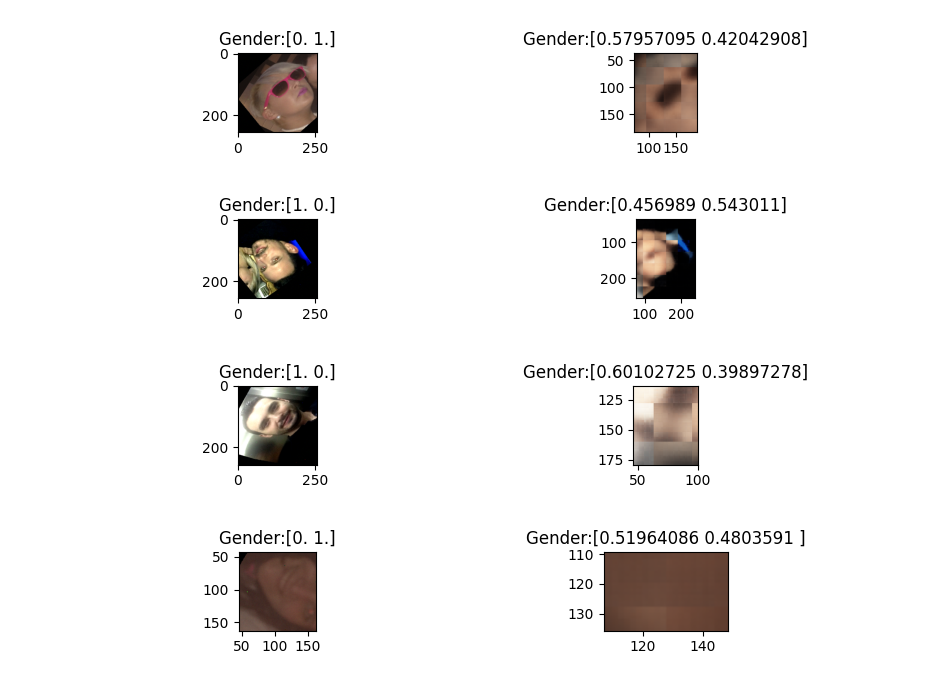

In [42]:
fig2, ax2 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=2)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax2[0].imshow(x/255)
    ax2[0].set_title(y['gender'])
    
    ax2[1].imshow(out['recon']/255)
    ax2[1].set_title(out['gender'])
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax2[i, 0].imshow(x[i]/255)
        ax2[i, 0].set_title(f"Gender:{y['gender'][i]}")
        
        ax2[i, 1].imshow(out['recon'][i]/255)
        ax2[i, 1].set_title(f"Gender:{out['gender'][i]}")
        
plt.tight_layout()